In [50]:
# !pip install trax
import os
import re
import shutil
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import optimizers
from trax.supervised import training

%matplotlib inline

In [2]:
nltk.download('punkt')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package punkt to /home/atom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train = pd.read_csv('../input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', header=0, delimiter='\t', quoting=3)
print(f'>>> Training set size {train.shape[0]}')
print('>>> Sample')
train.sample(10)

>>> Training set size 25000
>>> Sample


,id,sentiment,review
4343,"""11596_3""",0,"""\""The Dream Child\"" of 1989 is the fifth film..."
8396,"""9927_9""",1,"""Domino is a great movie. It's about a young w..."
494,"""9907_4""",0,"""DVD has become the equivalent of the old late..."
9971,"""8323_3""",0,"""From the beginning this movie did have a few ..."
23047,"""10260_1""",0,"""This movie was terrible!I rented it not knowi..."
8488,"""2687_1""",0,"""Eleven \""great\"" filmmakers, eleven pieces of..."
9314,"""10867_7""",1,"""I spotted in the guide to films list for the ..."
17010,"""7817_10""",1,"""What a brilliant film. I will admit it is ver..."
233,"""9277_1""",0,"""I saw the omen when i was 11 on tv. I enjoyed..."
6907,"""2522_4""",0,"""What an awful movie! The Idea of robots fight..."


In [4]:
rand_idx = random.randint(0, train.shape[0])
print(f'>>> Index: {rand_idx}, Id: {train.id.iloc[rand_idx]}')
print(f'\n>>> Sentiment: {train.sentiment.iloc[rand_idx]}')
rand_ex = train.review.iloc[rand_idx]
print(f'\n>>> Review: {rand_ex}')

>>> Index: 8310, Id: "2096_3"

>>> Sentiment: 0

>>> Review: "As a huge fan of only the first 2 seasons of BSG and the stand alone feature BSG Razor I was hoping that this release would return the franchise to its original glory days. Usually I have no problem with science fiction that is mostly dialog driven as opposed to a visual bonanza of special effects. If the script is tight with some original ideas delivered by good actors one can create a profound film with little CGI money spent. This prequel has none of those aforementioned requirements going for it. The virtual reality world created by the terrorist teenagers was both ridiculous & unbelievable. This scene was simply put there to raise the release rating to Restricted. Not that teens don't love virtual reality mosh pits filled with sex & violence & heavy dance music. Its the part about those same teens having the intellectual depth & reason or political & religious passion as to create such futuristic software or become suic

In [5]:
test = pd.read_csv('../input/word2vec-nlp-tutorial/testData.tsv.zip', header=0, delimiter='\t', quoting=3)
print(f'>>> Test set size {test.shape[0]}')
print('>>> Sample')
test.sample(10)

>>> Test set size 25000
>>> Sample


,id,review
20411,"""7605_2""","""This sequel is quite awful to be honest. I'm ..."
4940,"""11437_9""","""This is an enjoyable movie. Its very realisti..."
16179,"""12331_4""","""What to say about this movie? A married coupl..."
3105,"""1493_10""","""This is a wonderful family sitcom. Rowan Atki..."
6827,"""2461_7""","""This film easily rivals the emotional strengt..."
15774,"""10908_2""","""Another first: this French movie is my introd..."
23547,"""7246_3""","""I happened to have seen this movie this morni..."
19430,"""5470_1""","""Low budget junk about bloodthirsty cultists i..."
13038,"""2607_1""","""Wow. After seeing this film, you will know wh..."
11101,"""10937_8""","""This splicing of THE SEARCHERS is one of the ..."


In [6]:
unlabled_train = pd.read_csv('../input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip', header=0, delimiter='\t', quoting=3)
print(f'>>> Unlabled training set size {unlabled_train.shape[0]}')
print('>>> Sample')
unlabled_train.sample(10)

>>> Unlabled training set size 50000
>>> Sample


,id,review
4855,"""39550_0""","""Priscilla Lane begins the film as a secretary..."
4348,"""23657_0""","""\""The Unknown\"" returns to a theme common in ..."
9877,"""40145_0""","""I will admit I didn't pay full attention to e..."
13261,"""11251_0""","""There were some in the audience who couldn't ..."
4707,"""23661_0""","""The Unknown is a fabulous film; I didn't like..."
9828,"""25394_0""","""The first reviews which drew me to watch Keke..."
41797,"""24356_0""","""This movie...where to begin. A heavily mustac..."
17915,"""20809_0""","""This movies story line is all over the map, t..."
16265,"""1924_0""","""<br /><br />Garbage.The word fits this film t..."
41334,"""3617_0""","""This crime-time travel movie was interesting ..."


### Preparing the inputs and outputs

In [7]:
def sentence_to_words(sentence, all_words=None, remove_stopwords=False, remove_numbers=False, replace_numbers=None):
    sentence_text = BeautifulSoup(sentence).get_text()
    sentence_text = re.sub('[^a-zA-Z1-9]', ' ', sentence_text)
    if remove_numbers:
        sentence_text = re.sub('[1-9]', ' ', sentence_text)
    elif replace_numbers:
        sentence_text = re.sub('\s\d+[\.*\d+]*', f' {replace_numbers} ', sentence_text)
    words = sentence_text.lower().split()
    if remove_stopwords:
        words = [w.lower() for w in words if w not in STOPWORDS]
    if all_words is not None:
        all_words += words
    return words

<>:7: DeprecationWarning: invalid escape sequence '\s'


In [8]:
def review_to_sentences(review, tokenizer, all_sentences=None, all_words=None, remove_stopwords=False, remove_numbers=False, replace_numbers=None):
    raw_sentences = tokenizer(review.strip())
    sentences = []
    for sentence in raw_sentences:
        if len(sentence):
            words = sentence_to_words(sentence, all_words, remove_stopwords, remove_numbers, replace_numbers)
            if all_sentences is not None:
                all_sentences.append(words)
            sentences.append(words)
    return sentences

In [9]:
all_words = []
all_sentences = []
_ = train.review.apply(review_to_sentences, args=(sent_tokenize, all_sentences, all_words, True, False, 'NUM'))
_ = unlabled_train.review.apply(review_to_sentences, args=(sent_tokenize, all_sentences, all_words, True, False, 'NUM'))

/home/atom/work/nlp/nlpenv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/atom/work/nlp/nlpenv/lib/python3.10/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [10]:
fdist = nltk.FreqDist(word for word in all_words)
fdist.most_common(20)

[('movie', 132190),
 ('film', 121219),
 ('num', 113949),
 ('one', 81321),
 ('like', 60975),
 ('good', 44865),
 ('time', 37836),
 ('even', 37491),
 ('would', 37105),
 ('story', 35564),
 ('really', 34923),
 ('see', 34646),
 ('well', 32016),
 ('much', 29157),
 ('bad', 28358),
 ('get', 27918),
 ('people', 27877),
 ('also', 27505),
 ('great', 27441),
 ('first', 27137)]

In [11]:
# Since each movie occurs 30 times, we set the minimum word count to 40, to avoid attaching too much importance to individual movie titles
print(f'>>> Total of {len(fdist)} words counted')
useful_fdist = {w: c for w, c in fdist.items() if c >= 40}
print(f'>>> Selected {len(useful_fdist)} words appeared that appeared in 40 reviews or more')

>>> Total of 124149 words counted
>>> Selected 16348 words appeared that appeared in 40 reviews or more


In [12]:
# Preparing tokens to be fed to the model.
# For continuous skip-gram
#  Input: a one-hot-encoded center word.
#  Output: I don't know for sure. From reading the word2vec paper and the CBOW implementation, it's an average of the one-hot-encoded context words.
word2idx = {}
idx2word = {}
for idx, word in enumerate(useful_fdist.keys()):
    word2idx[word] = idx
    idx2word[idx] = word
word2idx['oov'] = len(word2idx)
idx2word[len(idx2word)] = 'oov'

In [13]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind.get(word, word2Ind['oov'])]
    return idx


def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed


def get_vectors(sentence, word2Ind, V, C):
    for i in range(0, len(sentence)):
        center_word = sentence[i]
        y = word2Ind.get(center_word, word2Ind['oov'])
        x = [0] * V
        context_words = sentence[max(0, i - C) : i] + sentence[min(len(sentence) - 1, i + 1) : min(len(sentence) - 1, i + C + 1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq / num_ctx_words
        yield x, y


def get_batches(sentences, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    example_weights = [1] * batch_size
    
    for sentence in sentences:
        for x, y in get_vectors(sentence, word2Ind, V, C):
            if len(batch_x) < batch_size:
                batch_x.append(x)
                batch_y.append(y)
            else:
                yield np.array(batch_x), np.array(batch_y), np.array(example_weights)
                batch_x = []
                batch_y = []
                
    if len(batch_x):
        yield np.array(batch_x), np.array(batch_y), np.array(example_weights)
        

### Building the model

In [14]:
# Building the model
def word2vec(word_vec_size, vocab_size):
    return tl.Serial(
        tl.Dense(word_vec_size),
        tl.Dense(vocab_size),
    )

### Training the model

In [15]:
# Empty the model directory, otherwise old checkpoints might fail to load and training would fail
MODEL_DIR = '../output'
def del_old_model(model_dir):
    for filename in os.listdir(model_dir):
        file_path = os.path.join(model_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
del_old_model(MODEL_DIR)

In [16]:
CUT_IDX = int(len(all_sentences) * 0.9)
train_task = training.TrainTask(
    labeled_data=get_batches(
        sentences=all_sentences[:CUT_IDX],
        word2Ind=word2idx,
        V=len(word2idx),
        C=5,
        batch_size=32,  
    ),
    loss_layer=tl.WeightedCategoryCrossEntropy(),
    optimizer=optimizers.Adam(0.001),
    n_steps_per_checkpoint=10,
)

eval_task = training.EvalTask(
    labeled_data=get_batches(
        sentences=all_sentences[CUT_IDX:],
        word2Ind=word2idx,
        V=len(word2idx),
        C=5,
        batch_size=32,  
    ),
    metrics=[
        tl.WeightedCategoryCrossEntropy(),
    ]
)

training_loop = training.Loop(
    model=word2vec(
        word_vec_size=300,
        vocab_size=len(word2idx)
    ),
    tasks=train_task,
    eval_tasks=eval_task,
    output_dir='../output',
)

/home/atom/work/nlp/nlpenv/lib/python3.10/site-packages/jax/_src/lib/xla_bridge.py:545: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [18]:
training_loop.run(n_steps=100)


Step    210: Ran 10 train steps in 31.09 secs
Step    210: train WeightedCategoryCrossEntropy |  8.40674210
Step    210: eval  WeightedCategoryCrossEntropy |  8.47289467

Step    220: Ran 10 train steps in 30.11 secs
Step    220: train WeightedCategoryCrossEntropy |  8.24342918
Step    220: eval  WeightedCategoryCrossEntropy |  8.46977329

Step    230: Ran 10 train steps in 29.77 secs
Step    230: train WeightedCategoryCrossEntropy |  8.29256821
Step    230: eval  WeightedCategoryCrossEntropy |  7.48742247

Step    240: Ran 10 train steps in 35.57 secs
Step    240: train WeightedCategoryCrossEntropy |  8.18574715
Step    240: eval  WeightedCategoryCrossEntropy |  8.07074642

Step    250: Ran 10 train steps in 30.21 secs
Step    250: train WeightedCategoryCrossEntropy |  8.22184181
Step    250: eval  WeightedCategoryCrossEntropy |  8.49355316

Step    260: Ran 10 train steps in 31.89 secs
Step    260: train WeightedCategoryCrossEntropy |  8.07393360
Step    260: eval  WeightedCategoryC

In [39]:
embeds = (training_loop.model.sublayers[0].weights[0] + training_loop.model.sublayers[1].weights[0].T)

In [43]:
embeds_pcs = PCA(n_components=2).fit_transform(embeds)

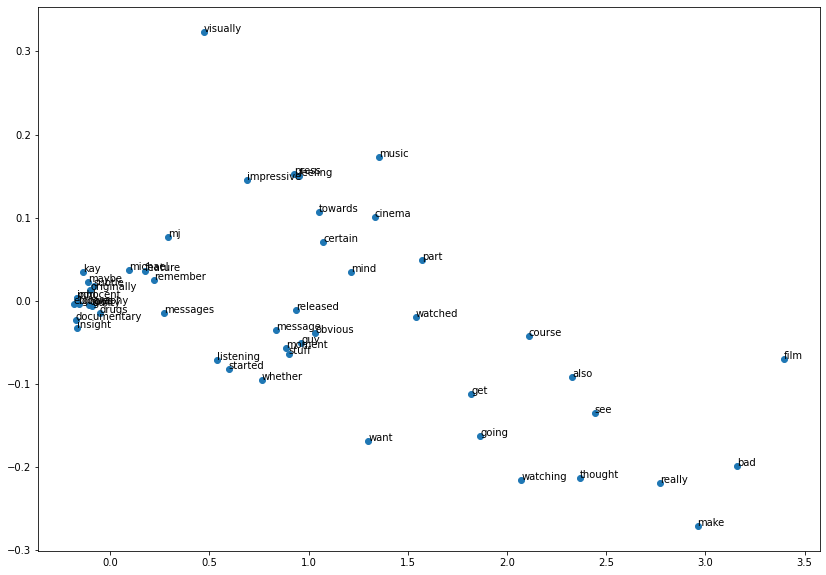

In [56]:
plt.figure(figsize=(14, 10))
plt.scatter(embeds_pcs[:50, 0], embeds_pcs[:50, 1])
for i, word in enumerate(list(word2idx.keys())[:50]):
    plt.annotate(word, xy=(embeds_pcs[i, 0], embeds_pcs[i, 1]))
plt.show()

In [57]:
from gensim.models import word2vec

/home/atom/work/nlp/nlpenv/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [59]:
model_gensim = word2vec.Word2Vec(
    sentences=all_sentences,
    workers=4, # Number of threads to run in parallel
    vector_size=300, # Word vector dimensionality
    min_count=40, # Minimum frequency of a word to be added to the vocabulary
    window=5, # Maximum distance between the current and predicted word within a sentence
    sample=1e-3, # Downsample setting for frequent words
)